In [7]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator
import os, sys, glob, warnings, glob    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib
import importlib
from importlib import reload
sys.path.append("/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
sys.path.insert(1, "/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
os.chdir('/home/owhgabri/My_GitHub/pyTracker')
print(os.getcwd())
print(joblib.__version__)

/home/owhgabri/My_GitHub/pyTracker
1.4.2


In [8]:
import scipy
import copy as cp

# ROOT
import ROOT as root

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

import pprint

In [9]:
import kalmanfilter as KF
import utilities as Util
import trackfinder as TF
import datatypes
from datatypes import *

reload(TF)
reload(Util)

<module 'utilities' from '/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker/utilities.py'>

In [10]:
def upVertex(vertex, tracks):
    """
    Returns true if all tracks provided 
    are going vertically upwards
    """
    for index in vertex.tracks:
        track = tracks[index]
        hits = track.hits_filtered
        point1 = hits[0]
        point2 = hits[-1]
        if point1[3] > point2[3]: # point 1 is later
            ydiff = point1[1] - point2[1]
            if ydiff < 1:
                return False
        else: #Point 2 is layter
            ydiff = point2[1] - point1[1]
            if ydiff < 1:
                return False
    return True
            
def getVertexType(vertex, tracks, hits):
    """
    Returns a list of types used by the tracks of the vertex
    """
    types = []
    for index in vertex.tracks:
        track = tracks[index]
        hits_used = track.hits
        for hit in hits:
            if hit.ind in hits_used and hit.type not in types:
                types.append(hit.type)
    return types

def checkCone(vertex, tracks):
    """
    Returns true if the cone from the tracks from the vertex encompass the CMS IP
    """
    drs = []
    CMSIP = np.zeros(3)
    # Get Backwards directional vectors
    for index in vertex.tracks:
        track = tracks[index]
        # Get the backwards direction
        hits = track.hits_filtered
        point1 = np.array(hits[0][:3])
        point2 = np.array(hits[-1][:3])
        t1 = hits[0][3]
        t2 = hits[-1][3]
        dr = np.zeros(3)
        if t1 > t2: # point 1 is later
            # Get backwards direction
            dr = point2 - point1
            dr = dr/np.linalg.norm(dr)
        else: #Point 2 is later
            # Get backwards direction
            dr = point1- point2
            dr = dr/np.linalg.norm(dr)
        drs.append(dr)
    # Dot product of unit vector of CMS with both directions should be
    # greater than dot product of both directions if inside
    vertexPoint = np.array([vertex.x0, vertex.y0, vertex.z0])
    drCMS = CMSIP - vertexPoint
    drCMS = drCMS / np.linalg.norm(drCMS)
    for direction1 in drs:
        for direction2 in drs:
            if np.array_equal(direction1, direction2):
                continue
            cosine1 = np.dot(direction1, drCMS)
            cosine2 = np.dot(direction2, drCMS)
            fullCosine = np.dot(direction1, direction2)
            if cosine1 <= fullCosine or cosine2 <= fullCosine:
                return False
    return True
    
        
        

In [11]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/10xCosmicBackground"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

98


In [12]:

all_hits = [] # List of lists: each sublist is an event
all_tracks = [] #List of lists: each sublist is an event
all_vertices = [] #List of lists: each sublist is an event
nLHC = 0
nLHC_cosmic = 0
nLHC_back = 0
ncosmic = 0
ncosmic_back = 0
nback = 0
nall = 0
nTotal = 0

for f in pathList: # Go through each file
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)): # For each event
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        all_hits.append(hits)
        all_tracks.append(tracks)
        all_vertices.append(vertices)
        nTotal += len(vertices)
        if len(vertices) == 0:
            continue
        for vertex in vertices: # For each track
            types = getVertexType(vertex, tracks, hits)
            if 0 in types and 1 in types and 2 in types:
                nall += 1
            elif 0 in types and 1 in types:
                nLHC_cosmic += 1
            elif 0 in types and 2 in types:
                nLHC_back +=1
            elif 1 in types and 2 in types:
                ncosmic_back += 1
            elif 0 in types:
                nLHC +=1
            elif 1 in types:
                ncosmic += 1
            elif 2 in types:
                nback += 1
                
print("Number of LHC only vertices :", nLHC)
print("Number of cosmic only vertices:", ncosmic)
print("Number of noise only vertices:", nback)
print("Number of LHC and cosmic vertices:", nLHC_cosmic)
print("Number of LHC and noise vertices:", nLHC_back)
print("Number of cosmic and noise vertices:", ncosmic_back)
print("Number of LHC, cosmic, and noise vertices:", nall)
print("Total number of vertices:", nTotal)

Number of LHC only vertices : 234
Number of cosmic only vertices: 75
Number of noise only vertices: 0
Number of LHC and cosmic vertices: 27
Number of LHC and noise vertices: 4
Number of cosmic and noise vertices: 6
Number of LHC, cosmic, and noise vertices: 5
Total number of vertices: 351


### Checking percentage of vertices that go up ### 

In [13]:
nLHC = 0
nLHC_cosmic = 0
nLHC_back = 0
ncosmic = 0
ncosmic_back = 0
nback = 0
nall = 0
nTotal = 0

for i in range(len(all_vertices)):
    vertices = all_vertices[i]
    tracks = all_tracks[i]
    hits = all_hits[i]
    if len(vertices) > 0:
        for vertex in vertices:
            types = getVertexType(vertex, tracks, hits)
            isUp = upVertex(vertex, tracks)
            if isUp:
                if 0 in types and 1 in types and 2 in types:
                    nall += 1
                elif 0 in types and 1 in types:
                    nLHC_cosmic += 1
                elif 0 in types and 2 in types:
                    nLHC_back +=1
                elif 1 in types and 2 in types:
                    ncosmic_back += 1
                elif 0 in types:
                    nLHC +=1
                elif 1 in types:
                    ncosmic += 1
                elif 2 in types:
                    nback += 1
            
                
print("Number of LHC only up vertices :", nLHC)
print("Number of cosmic only up vertices:", ncosmic)
print("Number of noise only up vertices:", nback)
print("Number of LHC and cosmic up vertices:", nLHC_cosmic)
print("Number of LHC and noise up vertices:", nLHC_back)
print("Number of cosmic and noise up vertices:", ncosmic_back)
print("Number of LHC, cosmic, and noise up vertices:", nall)
print("Total number of vertices:", nTotal)

Number of LHC only up vertices : 234
Number of cosmic only up vertices: 0
Number of noise only up vertices: 0
Number of LHC and cosmic up vertices: 0
Number of LHC and noise up vertices: 2
Number of cosmic and noise up vertices: 0
Number of LHC, cosmic, and noise up vertices: 2
Total number of vertices: 0


### Percentages of Vertices that include CMS in Their Backwards Cone ###

In [14]:
nLHC = 0
nLHC_cosmic = 0
nLHC_back = 0
ncosmic = 0
ncosmic_back = 0
nback = 0
nall = 0
nTotal = 0

for i in range(len(all_vertices)):
    vertices = all_vertices[i]
    tracks = all_tracks[i]
    hits = all_hits[i]
    if len(vertices) > 0:
        for vertex in vertices:
            types = getVertexType(vertex, tracks, hits)
            isInside = checkCone(vertex, tracks)
            if isInside:
                if 0 in types and 1 in types and 2 in types:
                    nall += 1
                elif 0 in types and 1 in types:
                    nLHC_cosmic += 1
                elif 0 in types and 2 in types:
                    nLHC_back +=1
                elif 1 in types and 2 in types:
                    ncosmic_back += 1
                elif 0 in types:
                    nLHC +=1
                elif 1 in types:
                    ncosmic += 1
                elif 2 in types:
                    nback += 1

print("Number of LHC vertices encompasing CMS:", nLHC)
print("Number of cosmic vertices encompasing CMS:", ncosmic)
print("Number of noise vertices encompassing CMS:", nback)
print("Number of LHC and cosmic up vertices encompassing CMS:", nLHC_cosmic)
print("Number of LHC and noise up vertices encompassing CMS:", nLHC_back)
print("Number of cosmic and noise up vertices encompassing CMS:", ncosmic_back)
print("Number of LHC, cosmic, and noise up vertices encompassing CMS:", nall)
print("Total number of vertices:", nTotal)

Number of LHC vertices encompasing CMS: 131
Number of cosmic vertices encompasing CMS: 0
Number of noise vertices encompassing CMS: 0
Number of LHC and cosmic up vertices encompassing CMS: 19
Number of LHC and noise up vertices encompassing CMS: 1
Number of cosmic and noise up vertices encompassing CMS: 1
Number of LHC, cosmic, and noise up vertices encompassing CMS: 2
Total number of vertices: 0


### Percentange of Vertices That Have X Number of Tracks ###

In [15]:
LHC = []
LHC_cosmic = []
LHC_back = []
cosmic = []
cosmic_back = []
back = []
alltypes = []

for i in range(len(all_vertices)):
    vertices = all_vertices[i]
    tracks = all_tracks[i]
    hits = all_hits[i]
    if len(vertices) > 0:
        for vertex in vertices:
            types = getVertexType(vertex, tracks, hits)
            nTracks = len(vertex.tracks)
            if 0 in types and 1 in types and 2 in types:
                alltypes.append(nTracks)
            elif 0 in types and 1 in types:
                LHC_cosmic.append(nTracks)
            elif 0 in types and 2 in types:
                LHC_back.append(nTracks)
            elif 1 in types and 2 in types:
                cosmic_back.append(nTracks)
            elif 0 in types:
                LHC.append(nTracks)
            elif 1 in types:
                cosmic.append(nTracks)
            elif 2 in types:
                back.append(nTracks)
everything = LHC + LHC_cosmic + LHC_back + cosmic + cosmic_back + back + alltypes
LHCcounts, LHCbins = np.histogram(LHC)
LHC_cosmiccounts, LHC_cosmicbins = np.histogram(LHC_cosmic)
LHC_backcounts,LHC_backbins = np.histogram(LHC_back)
cosmiccounts,cosmicbins = np.histogram(cosmic)
cosmic_backcounts,cosmic_backbins = np.histogram(cosmic_back)
backcounts,backbins = np.histogram(back)
alltypescounts,alltypesbins = np.histogram(alltypes)
everythingcounts, everythingbins = np.histogram(everything)

print("LHC with 2:", (LHCcounts[0]/sum(LHCcounts))*100)
print("Cosmic with 2:", (cosmiccounts[0]/sum(cosmiccounts))*100)
print("LHC and cosmic with 2:", (LHC_cosmiccounts[0]/sum(LHC_cosmiccounts))*100)
print("LHC and noise with 2:", (LHC_backcounts[0]/sum(LHC_backcounts))*100)
print("cosmic and noise with 2:", (cosmic_backcounts[0]/sum(cosmic_backcounts))*100)
print("Everything with 2:", (everythingcounts[0]/sum(everythingcounts))*100)


LHC with 2: 96.15384615384616
Cosmic with 2: 0.0
LHC and cosmic with 2: 0.0
LHC and noise with 2: 75.0
cosmic and noise with 2: 0.0
Everything with 2: 97.15099715099716


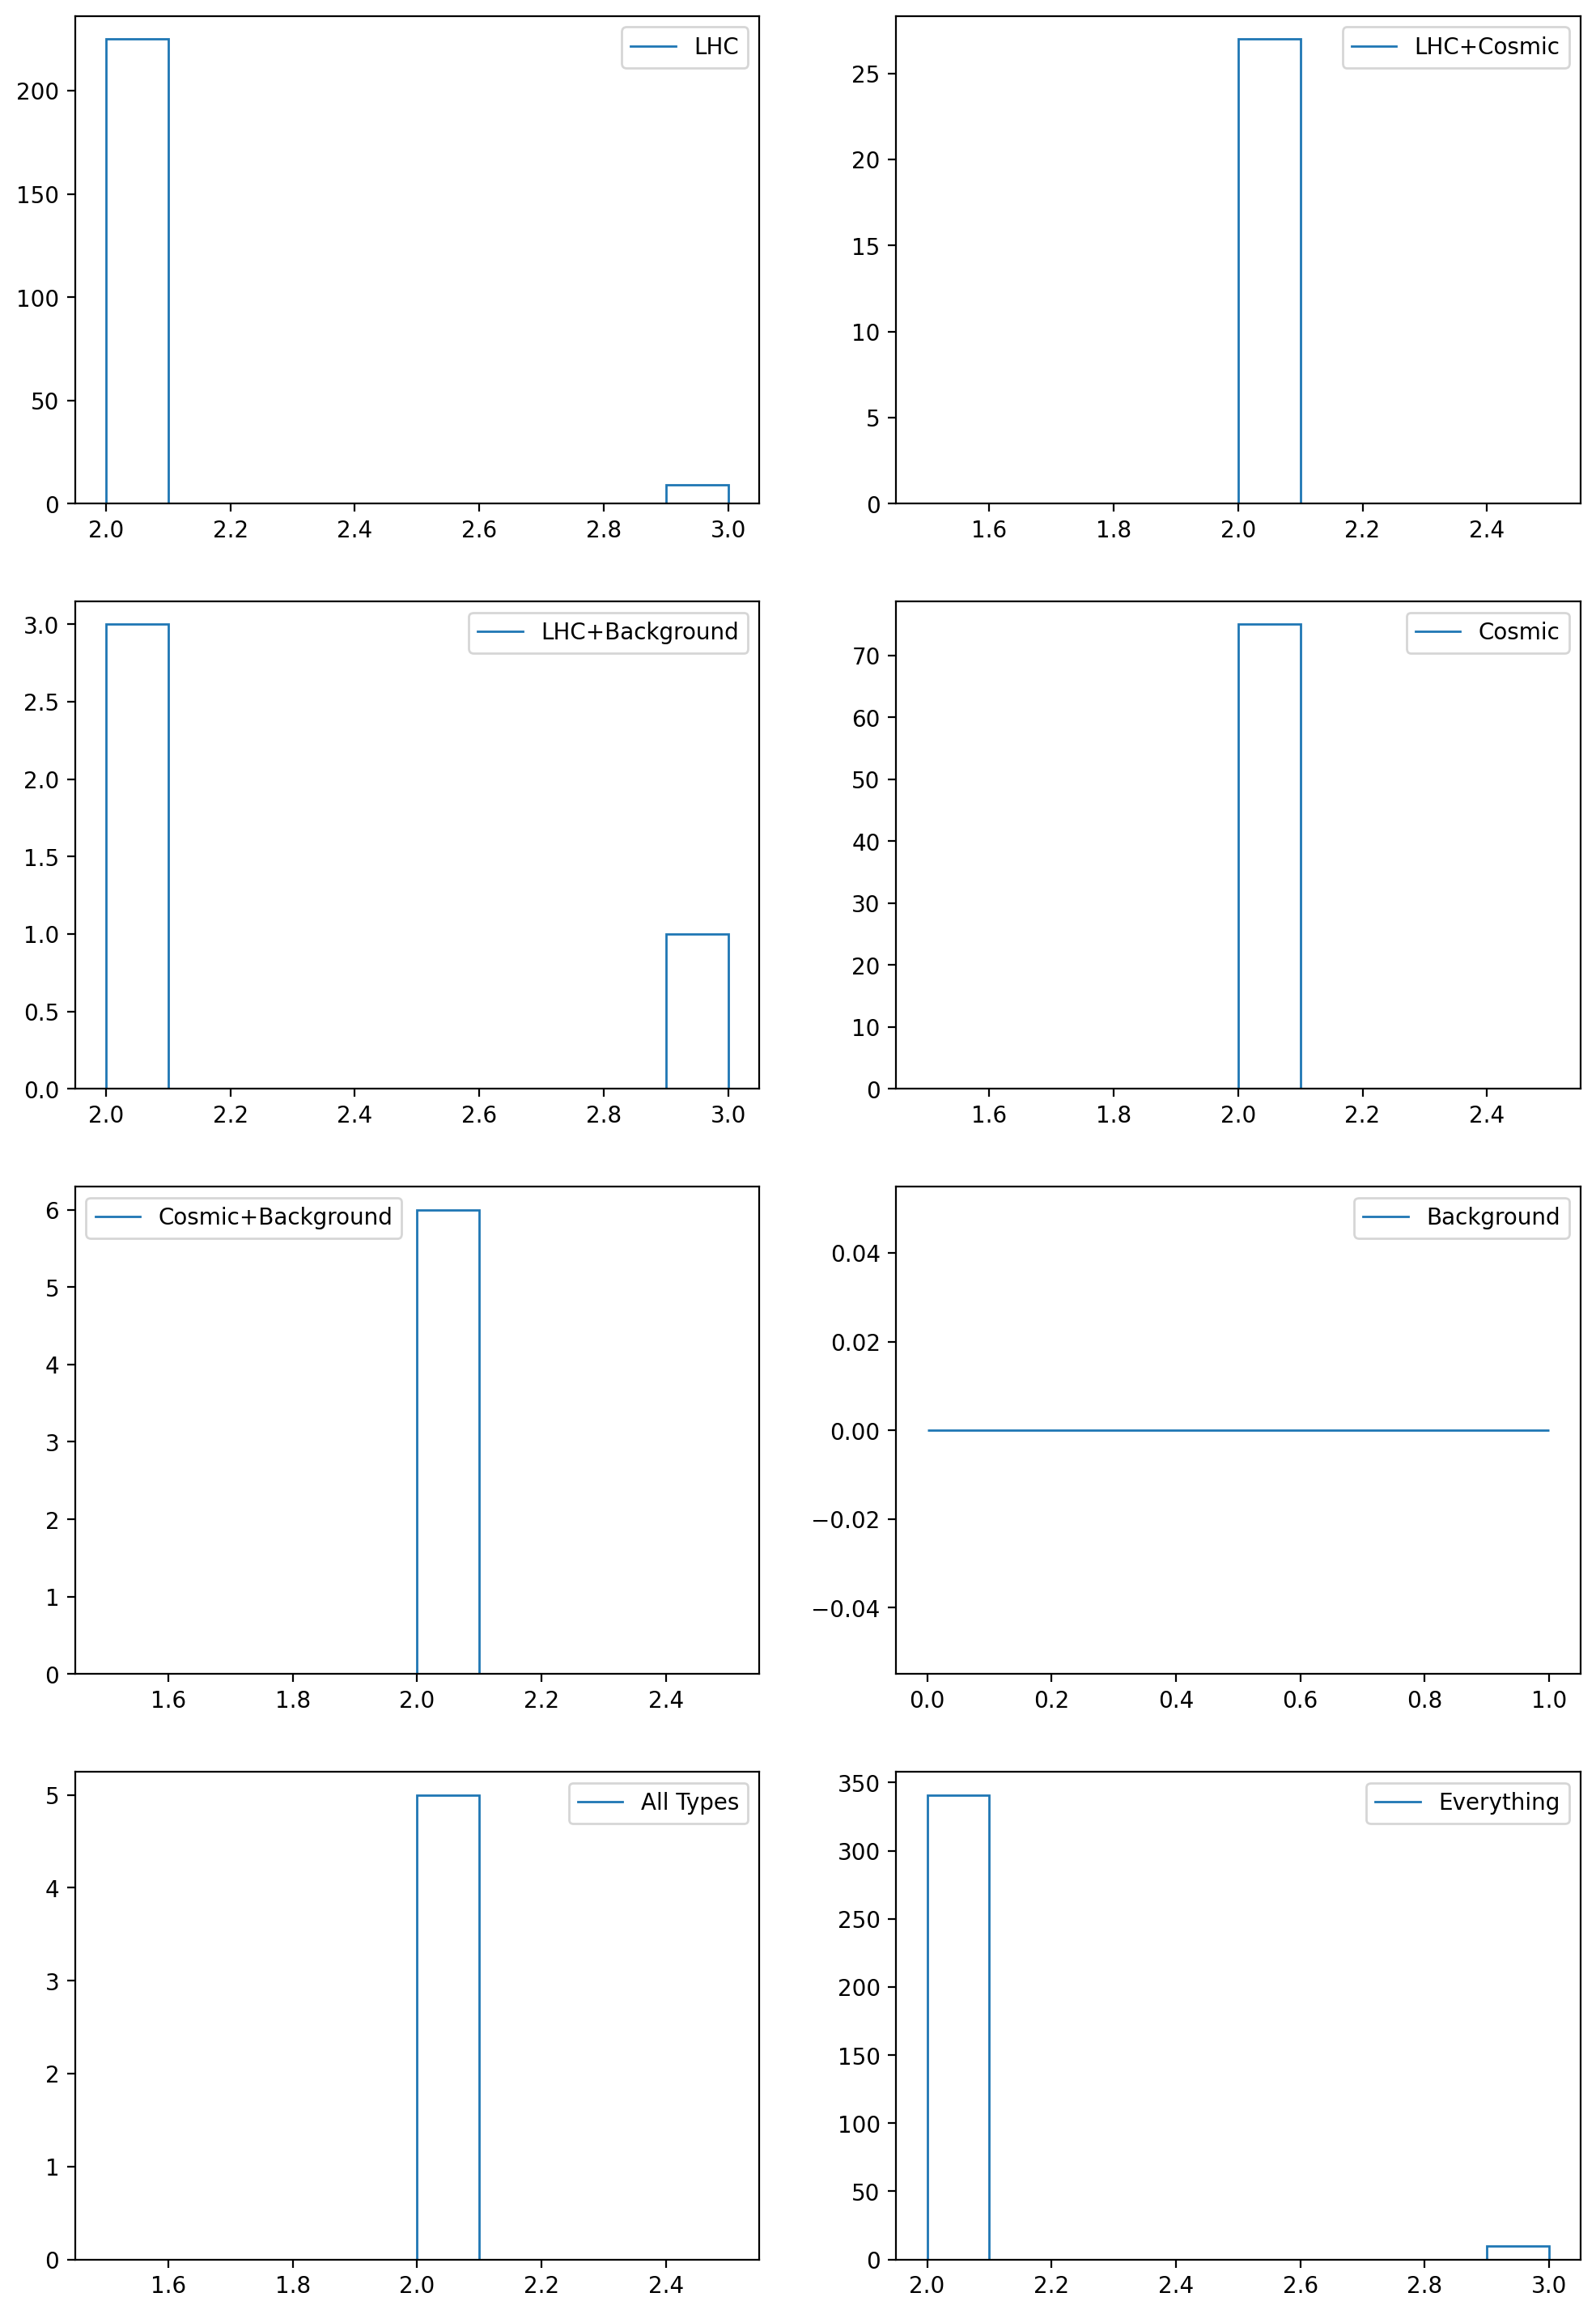

In [16]:
fig,axs=plt.subplots(4,2,figsize=(12,18))
axs=axs.flatten().tolist()

axs[0].stairs(LHCcounts, LHCbins, label="LHC")
axs[1].stairs(LHC_cosmiccounts, LHC_cosmicbins, label="LHC+Cosmic")
axs[2].stairs(LHC_backcounts, LHC_backbins, label="LHC+Background")
axs[3].stairs(cosmiccounts, cosmicbins, label="Cosmic")
axs[4].stairs(cosmic_backcounts, cosmic_backbins, label="Cosmic+Background")
axs[5].stairs(backcounts, backbins, label="Background")
axs[6].stairs(alltypescounts, alltypesbins, label="All Types")
axs[7].stairs(everythingcounts, everythingbins, label="Everything")
for i in range(len(axs)):
    axs[i].legend()

### Percentage of Vertices that are both up and encompass the IP ###

In [17]:
nLHC = 0
nLHC_cosmic = 0
nLHC_back = 0
ncosmic = 0
ncosmic_back = 0
nback = 0
nall = 0
nTotal = 0

for i in range(len(all_vertices)):
    vertices = all_vertices[i]
    tracks = all_tracks[i]
    hits = all_hits[i]
    if len(vertices) > 0:
        for vertex in vertices:
            types = getVertexType(vertex, tracks, hits)
            isInside = checkCone(vertex, tracks)
            upwards = upVertex(vertex, tracks)
            if isInside and upwards:
                if 0 in types and 1 in types and 2 in types:
                    nall += 1
                elif 0 in types and 1 in types:
                    nLHC_cosmic += 1
                elif 0 in types and 2 in types:
                    nLHC_back +=1
                elif 1 in types and 2 in types:
                    ncosmic_back += 1
                elif 0 in types:
                    nLHC +=1
                elif 1 in types:
                    ncosmic += 1
                elif 2 in types:
                    nback += 1

print("Number of LHC vertices encompasing CMS:", nLHC)
print("Number of cosmic vertices encompasing CMS:", ncosmic)
print("Number of noise vertices encompassing CMS:", nback)
print("Number of LHC and cosmic up vertices encompassing CMS:", nLHC_cosmic)
print("Number of LHC and noise up vertices encompassing CMS:", nLHC_back)
print("Number of cosmic and noise up vertices encompassing CMS:", ncosmic_back)
print("Number of LHC, cosmic, and noise up vertices encompassing CMS:", nall)
print("Total number of vertices:", nTotal)

Number of LHC vertices encompasing CMS: 131
Number of cosmic vertices encompasing CMS: 0
Number of noise vertices encompassing CMS: 0
Number of LHC and cosmic up vertices encompassing CMS: 0
Number of LHC and noise up vertices encompassing CMS: 0
Number of cosmic and noise up vertices encompassing CMS: 0
Number of LHC, cosmic, and noise up vertices encompassing CMS: 1
Total number of vertices: 0
